# Decision tree

for analysis of weather data

In [4]:
import opendatasets as od 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
import os

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Downloading datasets

In [5]:
od.download('http://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Skipping, found downloaded files in ".\weather-dataset-rattle-package" (use force=True to force download)


In [6]:
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')

Drop rows with missing values

In [7]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

### Preparing Data

In [8]:
year = pd.to_datetime(raw_df.Date).dt.year

# split the data into train, validation and test
train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

1. Separate the data into training and test sets

In [9]:
input_cols = list(train_df.columns)[1:-1]
target_cols = 'RainTomorrow'

In [10]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_cols].copy()

In [11]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_cols].copy()

In [12]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_cols].copy()

In [13]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
catagorical_cols = train_inputs.select_dtypes('object').columns.tolist()

2. Impute missing numeric values

In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

In [15]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

3. Scaling numeric features

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [17]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

4. Encoding categorical variables

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [62]:
train_inputs[catagorical_cols] = train_inputs[catagorical_cols].fillna('Unknown', inplace=True)
val_inputs[catagorical_cols] = val_inputs[catagorical_cols].fillna('Unknown', inplace=True)
test_inputs[catagorical_cols] = test_inputs[catagorical_cols].fillna('Unknown', inplace=True)

C:\Users\tanav\AppData\Local\Temp\ipykernel_23412\822109253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs[catagorical_cols] = train_inputs[catagorical_cols].fillna('Unknown', inplace=True)
C:\Users\tanav\AppData\Local\Temp\ipykernel_23412\822109253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_inputs[catagorical_cols] = val_inputs[catagorical_cols].fillna('Unknown', inplace=True)
C:\Users\tanav\AppData\Local\Temp\ipykernel_23412\822109253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [63]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[catagorical_cols])

In [64]:
encoded_cols = list(encoder.get_feature_names_out(catagorical_cols))

In [65]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[catagorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[catagorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[catagorical_cols])

In [66]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = val_inputs[numeric_cols + encoded_cols] 

## Decision tree

1. Training

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
# some fixed value for optimal performance
model = DecisionTreeClassifier(random_state=42)

In [26]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

2. Evaluation

In [27]:
train_preds = model.predict(X_train)

In [28]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [29]:
pd.value_counts(train_preds)

C:\Users\tanav\AppData\Local\Temp\ipykernel_23412\1258350197.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


No     76707
Yes    22281
Name: count, dtype: int64

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [31]:
# accuracy of model (similarity bw train_preds and train_targets)
accuracy_score(train_preds, train_targets)

0.9999797955307714

In [32]:
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [33]:
model.score(X_val, val_targets)

0.783529684870292

here the model has score very less as compared to the model on train data. we'll try to make it better. this is known as overfitting.

3. Visualize the data

In [34]:
from sklearn.tree import plot_tree, export_text

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]'),
 Text(0.625, 0.375, 'WindGustSpeed <= 0.279\ngini = 0.499\nsamples = 9136\nvalue = [4804, 4332]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Rainfall <= 0.01\ngini = 0.316\nsamples = 7434\nvalue = [1462, 5972]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

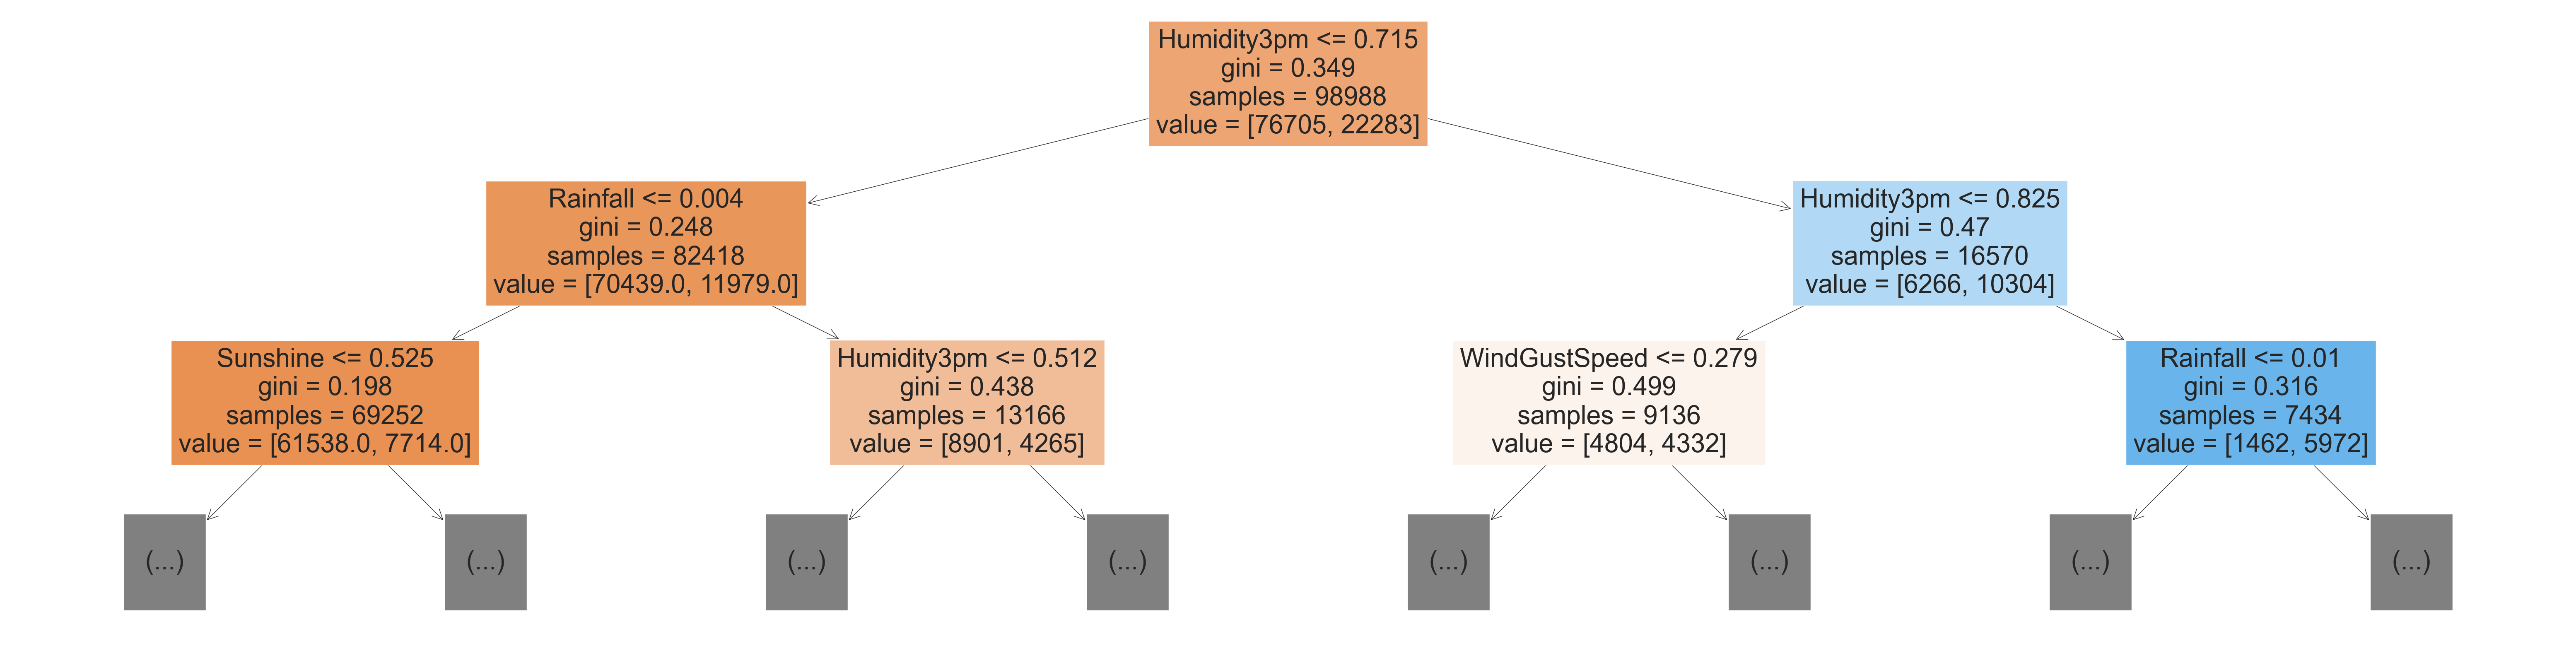

In [35]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True)

In [36]:
model.tree_.max_depth

49

In [37]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- Cloud9am <= 0.61
|   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |--- Sunshine <= 0.41
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |--- Sunshine >  0.41
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.33
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- MinTemp >  0.33
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.51
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  

### Imporance Values

In [38]:
model.feature_importances_

array([0.0517289 , 0.04827607, 0.06785345, 0.0350833 , 0.06171954,
       0.06510195, 0.0413171 , 0.0415716 , 0.05257636, 0.26850778,
       0.0512326 , 0.07713791, 0.01968553, 0.02381602, 0.04826022,
       0.04613167, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [39]:
importance_df = pd.DataFrame({
  'feature': X_train.columns,
  'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [40]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.268508
11,Pressure3pm,0.077138
2,Rainfall,0.067853
5,WindGustSpeed,0.065102
4,Sunshine,0.061720
8,Humidity9am,0.052576
0,MinTemp,0.051729
10,Pressure9am,0.051233
1,MaxTemp,0.048276
14,Temp9am,0.048260


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

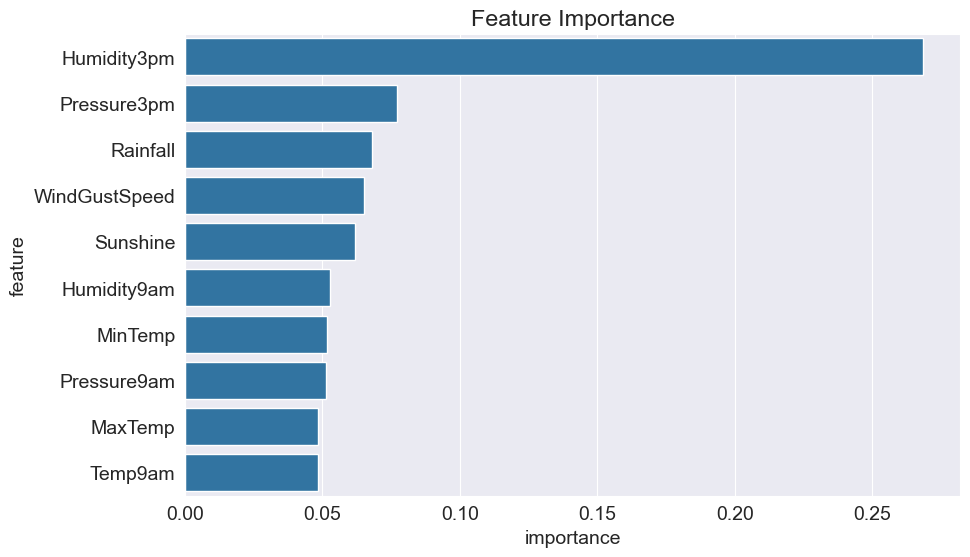

In [41]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

### Better validation scores
we want model to take genral trends not memorize all of them

In [42]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [43]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [44]:
model.score(X_train, train_targets)

0.8291308037337859

In [45]:
model.score(X_val, val_targets)

0.8334397307178921

though model is not that good at train data, but far more better on new data. which is superb, model is not longer overfitting.

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]'),
 Text(0.625, 0.375, 'WindGustSpeed <= 0.279\ngini = 0.499\nsamples = 9136\nvalue = [4804, 4332]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Rainfall <= 0.01\ngini = 0.316\nsamples = 7434\nvalue = [1462, 5972]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

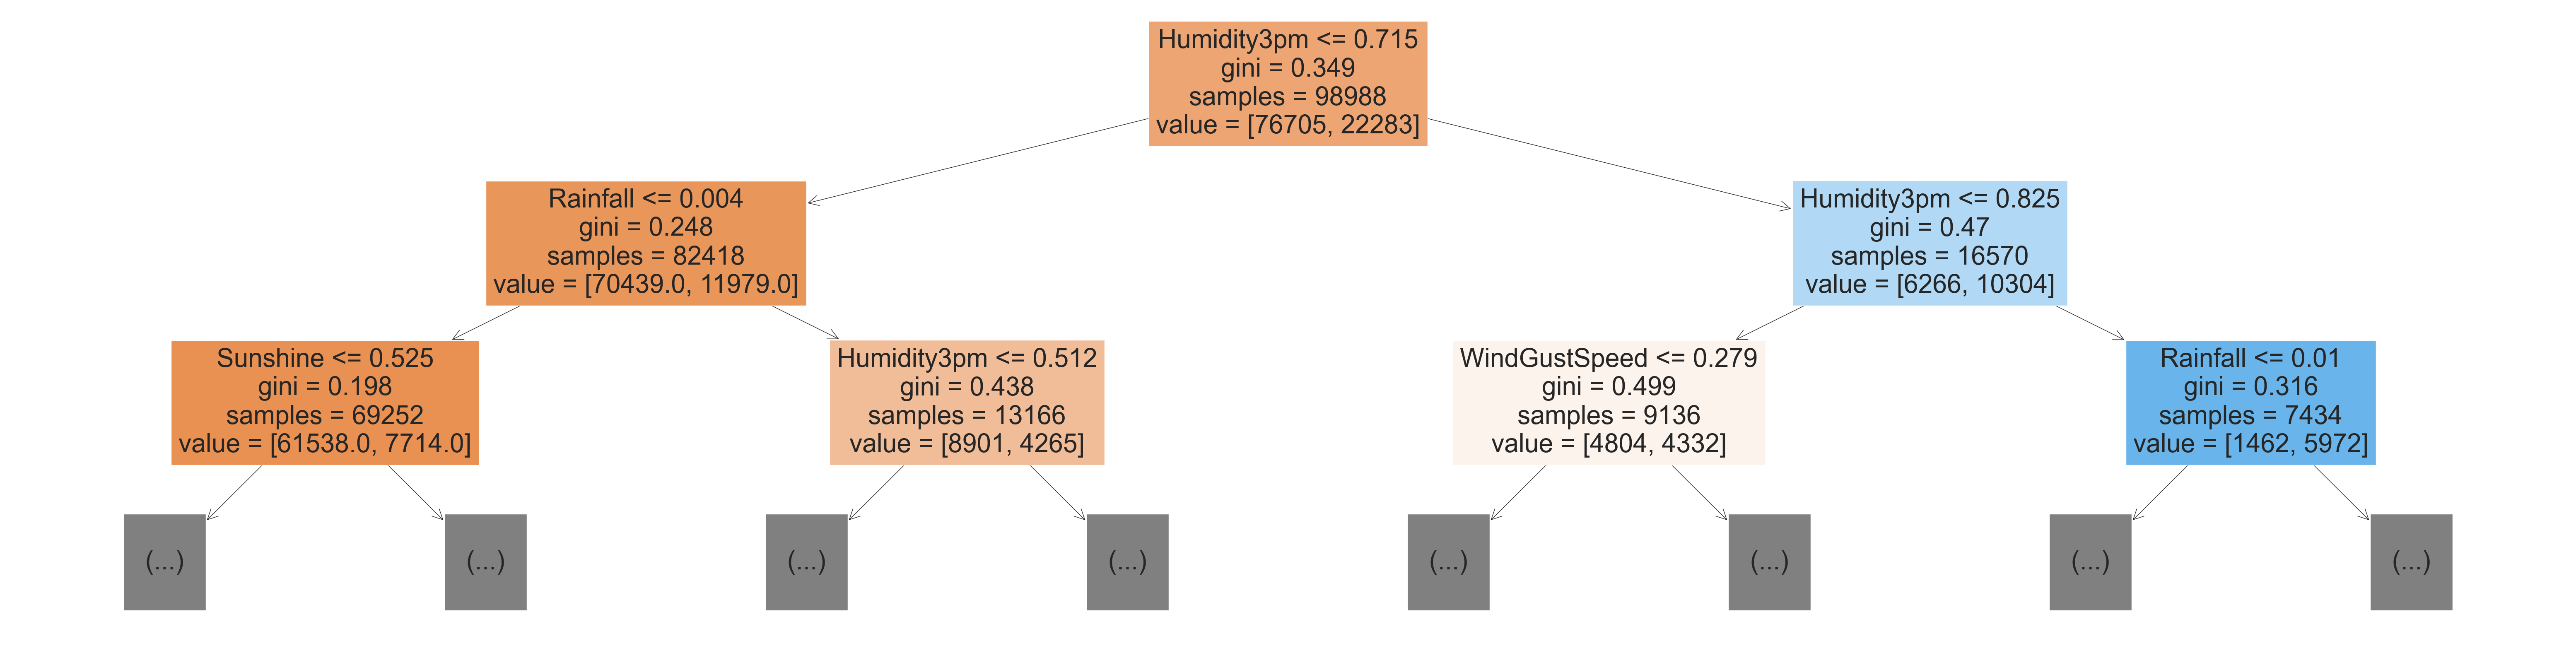

In [46]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True)

In [47]:
def max_depth_error(md):
  model = DecisionTreeClassifier(max_depth=md, random_state=42)
  model.fit(X_train, train_targets)
  train_error = 1-model.score(X_train, train_targets)
  val_error = 1-model.score(X_val, val_targets)
  return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': val_error}

In [48]:
error_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

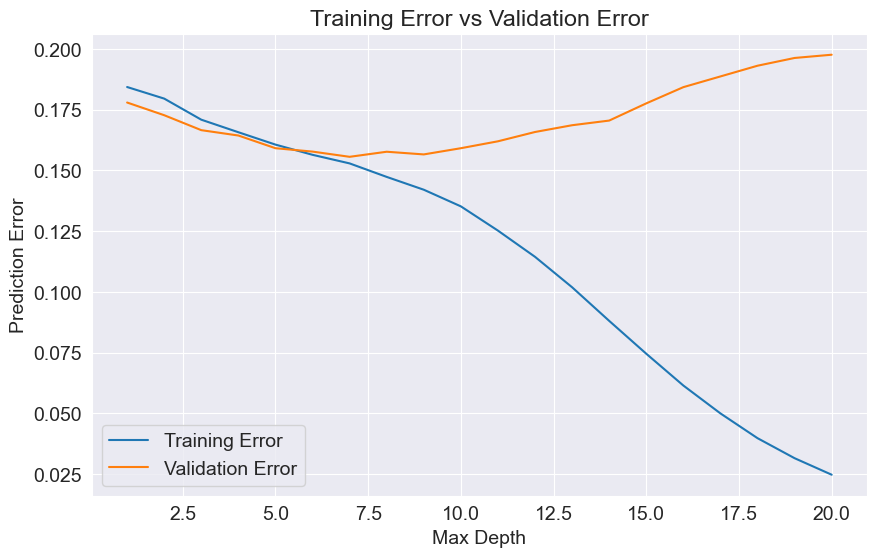

In [49]:
plt.figure()
plt.plot(error_df['Max Depth'], error_df['Training Error'])
plt.plot(error_df['Max Depth'], error_df['Validation Error'])
plt.title('Training Error vs Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Prediction Error')
plt.legend(['Training Error', 'Validation Error'])

<- underfiting | overfitting ->